# Ray Jennings
# Feature Importance with SHAP and eli5

In [4]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

import eli5
from eli5.sklearn import PermutationImportance
import shap
import lime
import lime.lime_tabular

## Part 1 - EDA

In [5]:
#
# Read Heart Failure dataset
#

df = pd.read_csv('./heart_failure_clinical_records_dataset.csv', index_col=False)
df.reset_index(drop=True, inplace=True)

df.head()

age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  75.0        0                       582         0                 20   
1  55.0        0                      7861         0                 38   
2  65.0        0                       146         0                 20   
3  50.0        1                       111         0                 20   
4  65.0        1                       160         1                 20   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1  265000.00               1.9           130    1   
1                    0  263358.03               1.1           136    1   
2                    0  162000.00               1.3           129    1   
3                    0  210000.00               1.9           137    1   
4                    0  327000.00               2.7           116    0   

   smoking  time  DEATH_EVENT  
0        0     4            1  
1        0     6            1  
2        1     7            1  
3        0     7            1  
4        0     8            1

### Check for mising values

In [6]:
df.isna().any()

age                         False
anaemia                     False
creatinine_phosphokinase    False
diabetes                    False
ejection_fraction           False
high_blood_pressure         False
platelets                   False
serum_creatinine            False
serum_sodium                False
sex                         False
smoking                     False
time                        False
DEATH_EVENT                 False
dtype: bool

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [8]:
df.describe()

age     anaemia  creatinine_phosphokinase    diabetes  \
count  299.000000  299.000000                299.000000  299.000000   
mean    60.833893    0.431438                581.839465    0.418060   
std     11.894809    0.496107                970.287881    0.494067   
min     40.000000    0.000000                 23.000000    0.000000   
25%     51.000000    0.000000                116.500000    0.000000   
50%     60.000000    0.000000                250.000000    0.000000   
75%     70.000000    1.000000                582.000000    1.000000   
max     95.000000    1.000000               7861.000000    1.000000   

       ejection_fraction  high_blood_pressure      platelets  \
count         299.000000           299.000000     299.000000   
mean           38.083612             0.351171  263358.029264   
std            11.834841             0.478136   97804.236869   
min            14.000000             0.000000   25100.000000   
25%            30.000000             0.000000  212500.000000   
50%            38.000000             0.000000  262000.000000   
75%            45.000000             1.000000  303500.000000   
max            80.000000             1.000000  850000.000000   

       serum_creatinine  serum_sodium         sex    smoking        time  \
count         299.00000    299.000000  299.000000  299.00000  299.000000   
mean            1.39388    136.625418    0.648829    0.32107  130.260870   
std             1.03451      4.412477    0.478136    0.46767   77.614208   
min             0.50000    113.000000    0.000000    0.00000    4.000000   
25%             0.90000    134.000000    0.000000    0.00000   73.000000   
50%             1.10000    137.000000    1.000000    0.00000  115.000000   
75%             1.40000    140.000000    1.000000    1.00000  203.000000   
max             9.40000    148.000000    1.000000    1.00000  285.000000   

       DEATH_EVENT  
count    299.00000  
mean       0.32107  
std        0.46767  
min        0.00000  
25%        0.00000  
50%        0.00000  
75%        1.00000  
max        1.00000

<br>

### Apply Standard Scaler to entire dataframe - except target feature
<p>Target Feature of 1 == Died</p>
<p>Target Feature of 0 == Lived</p>

In [9]:
y_data = df.iloc[:,[12]]
print("Target Feature:")
print(y_data.columns)
print("\n")

ss = StandardScaler()
df = pd.DataFrame(ss.fit_transform(df),columns = df.columns)
df.head()


print("Independent Features:")
X_data = df.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11]]
print(X_data.columns)

Target Feature:
Index(['DEATH_EVENT'], dtype='object')


Independent Features:
Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time'],
      dtype='object')


<br>

### Correlation Heatmap

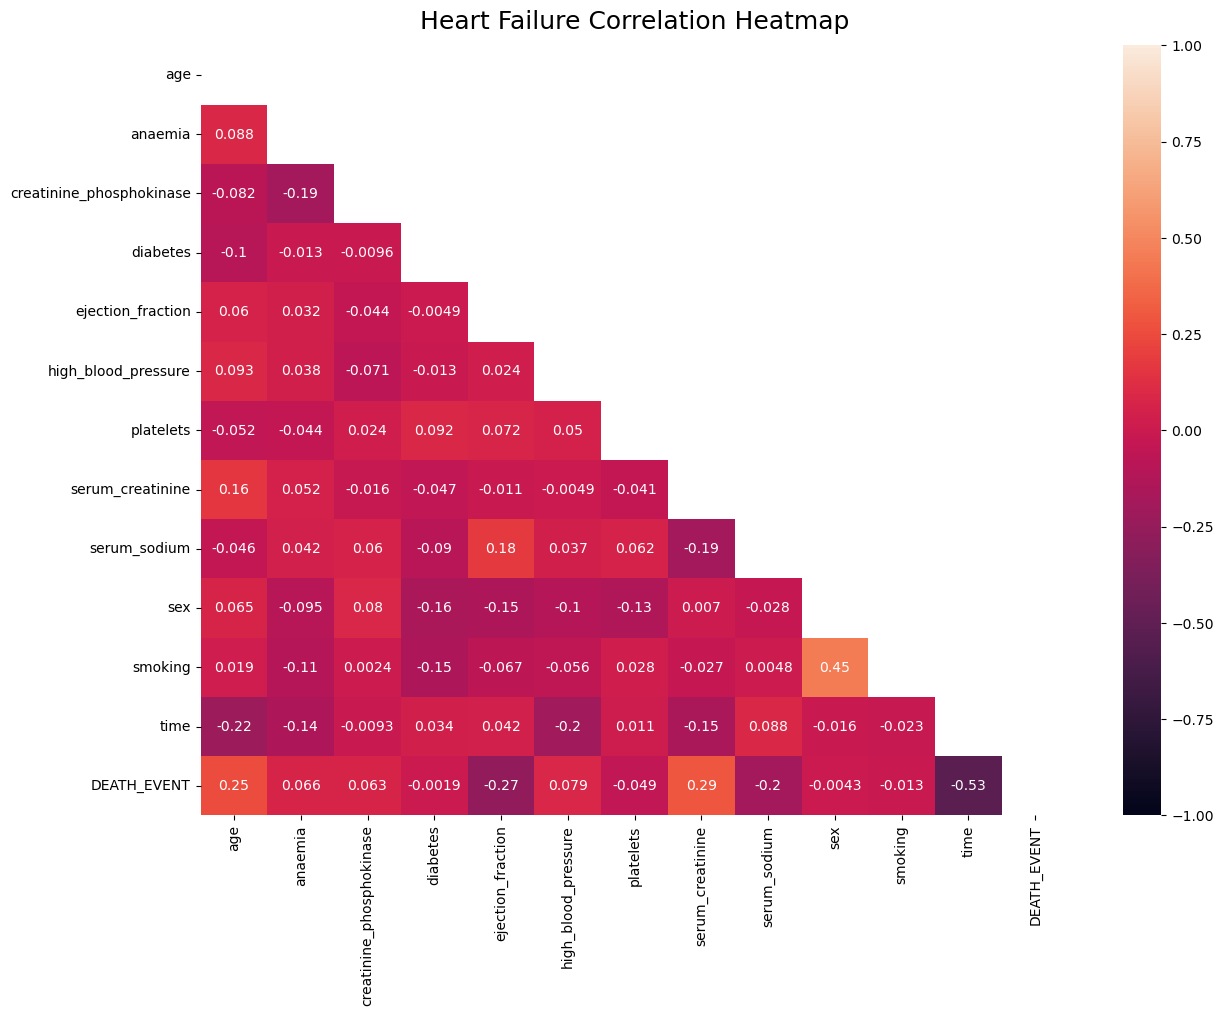

In [10]:
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
plt.figure(figsize=(14, 10))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True);
heatmap.set_title('Heart Failure Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

### Correlation with Target (DEATH_EVENT)

In [11]:
df.corrwith(df['DEATH_EVENT'])

age                         0.253729
anaemia                     0.066270
creatinine_phosphokinase    0.062728
diabetes                   -0.001943
ejection_fraction          -0.268603
high_blood_pressure         0.079351
platelets                  -0.049139
serum_creatinine            0.294278
serum_sodium               -0.195204
sex                        -0.004316
smoking                    -0.012623
time                       -0.526964
DEATH_EVENT                 1.000000
dtype: float64

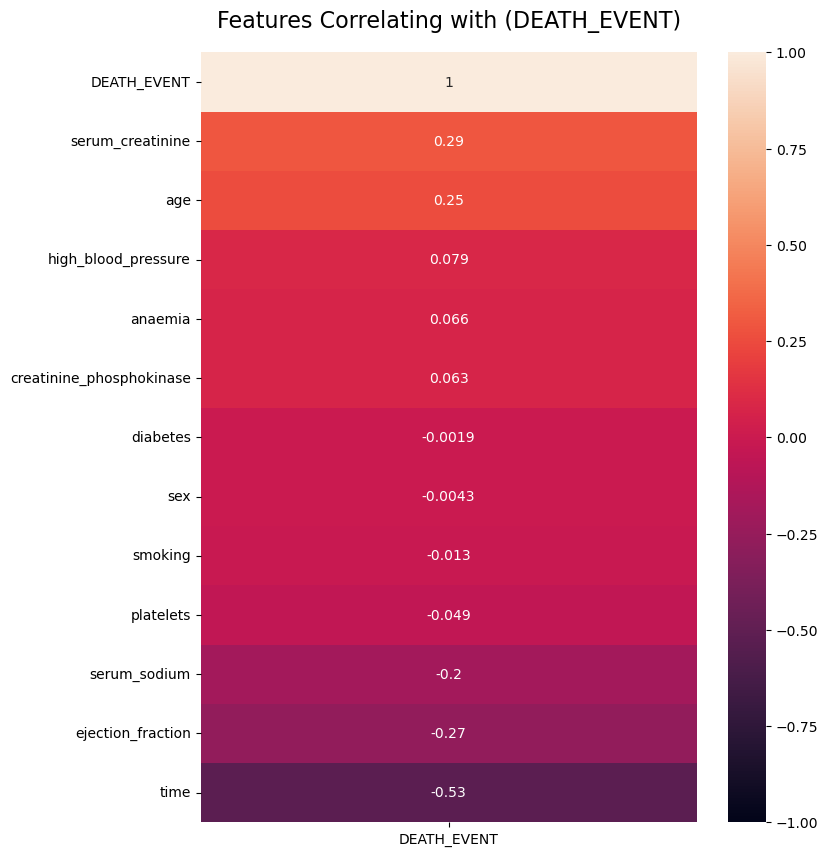

In [12]:
plt.figure(figsize=(8, 10))
heatmap = sns.heatmap(df.corr()[['DEATH_EVENT']].sort_values(by='DEATH_EVENT', ascending=False),
                      vmin=-1, vmax=1, annot=True)
heatmap.set_title('Features Correlating with (DEATH_EVENT)', fontdict={'fontsize':16}, pad=18);

<br>

## Part 2 - Machine Learning Models

In [13]:
#
# Train/Test Split - 30% for test
#

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=1)

y_train = y_train.values
y_train = y_train.reshape(1, -1)
y_train = y_train.flatten()

y_test = y_test.values
y_test = y_test.reshape(1, -1)
y_test = y_test.flatten()

<br>

### _Logistic Regression - Grid Search_

In [14]:
parameters = [
    {
     'solver': ['lbfgs'],
     'penalty': ['l2', 'none']
    },
    {
     'solver': ['liblinear'],
     'penalty': ['l1', 'l2'],
    },
    {
     'solver': ['newton-cg'],
     'penalty': ['l2', 'none'],
    },
    {
     'solver': ['sag'],
     'penalty': ['l2', 'none'],
    },
    {
     'solver': ['saga'],
     'penalty': ['l1', 'l2', 'none'],
    },
    {
     'solver': ['saga'],
     'penalty': ['elasticnet'],
     'l1_ratio': [1]
    } 
    
    #l1_ratio=1 'l1', 
]

lr_classifier = GridSearchCV(estimator=LogisticRegression(random_state=0), param_grid=parameters, refit=True, verbose=1,
                    return_train_score=True, n_jobs=-1) 

# Fit the model for grid search 
lr_classifier.fit(X_train, y_train)

# Show best parameters
print("\nBest Parameters:")
print(lr_classifier.best_params_)
print()

predict = lr_classifier.predict(X_test)

accuracy_lr_classifier = np.mean(predict == y_test)

print("Logistic Regression Accuracy: " + str(accuracy_lr_classifier))
print()
print("ROC-AUC Score: " + str(roc_auc_score(y_test, predict, average=None)))

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best Parameters:
{'penalty': 'l2', 'solver': 'lbfgs'}

Logistic Regression Accuracy: 0.8333333333333334

ROC-AUC Score: 0.7686298076923077


/opt/anaconda3/envs/tensorflow3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/anaconda3/envs/tensorflow3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/anaconda3/envs/tensorflow3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/anaconda3/envs/tensorflow3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.wa

<br>

### _Decision Tree Classifier - Grid Search_

In [15]:
parameters = [
    {'criterion': ['gini', 'entropy', 'log_loss'], 
     'splitter': ['best', 'random'],
     'class_weight': [{0:8,1:2}, 'balanced']
    }
]

dtree_classifier = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0), param_grid=parameters, refit=True,
                    verbose=1, return_train_score=True, n_jobs=-1) 

# Fit the model for grid search 
dtree_classifier.fit(X_train, y_train) 
 
# Show best parameters
print("\nBest Parameters:")
print(dtree_classifier.best_params_)
print()

# Run prediction with best parameters
predict = dtree_classifier.predict(X_test)
accuracy_dtree_classifier = np.mean(predict == y_test)

print("Decision Tree Accuracy: " + str(accuracy_dtree_classifier))
print()
print("ROC-AUC Score: " + str(roc_auc_score(y_test, predict, average=None)))

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best Parameters:
{'class_weight': {0: 8, 1: 2}, 'criterion': 'entropy', 'splitter': 'best'}

Decision Tree Accuracy: 0.8333333333333334

ROC-AUC Score: 0.7914663461538461


<br>

### _Random Forest - Grid Search_

In [16]:
parameters = [
    {'n_estimators': [10, 100, 200, 500],
     'criterion': ['gini', 'entropy', 'log_loss'],
     'bootstrap': [True, False],
     'class_weight': [{0:8,1:2}, 'balanced', 'balanced_subsample']
    }
]

rf_classifier = GridSearchCV(estimator=RandomForestClassifier(random_state=0), param_grid=parameters,
                    refit=True, verbose=1, return_train_score=True, n_jobs=-1) 

# Fit the model for grid search 
rf_classifier.fit(X_train, y_train) 
 
# Show best parameters
print("\nBest Parameters:")
print(rf_classifier.best_params_)
print()

# Run prediction with best parameters
predict = rf_classifier.predict(X_test)
accuracy_rf_classifier = np.mean(predict == y_test)

print("Decision Tree Accuracy: " + str(accuracy_rf_classifier))
print()
print("ROC-AUC Score: " + str(roc_auc_score(y_test, predict, average=None)))

Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best Parameters:
{'bootstrap': True, 'class_weight': 'balanced_subsample', 'criterion': 'gini', 'n_estimators': 100}

Decision Tree Accuracy: 0.8888888888888888

ROC-AUC Score: 0.8419471153846154


<br>

### _XGBoost - Grid Search_

In [17]:
parameters = [
    {
        'n_estimators': [5, 10, 15, 20, 50, 100, 200, 500],
        'booster': ['gbtree', 'gblinear', 'dart'],
        'eval_metric': ['mlogloss', 'auc', 'rmse'],
        'learning_rate': [0.5, 0.1, 0.05, 0.01],
    }
]

xgb_classifier = GridSearchCV(estimator=XGBClassifier(random_state=0), param_grid=parameters, refit=True, verbose=1,
                              return_train_score=True, n_jobs=-1) 

# Fit the model for grid search 
xgb_classifier.fit(X_train, y_train) 
 
# Show best parameters
print("\nBest Parameters:")
print(xgb_classifier.best_params_)
print()

# Run prediction with best parameters
predict = xgb_classifier.predict(X_test)
accuracy_xgb_classifier = np.mean(predict == y_test)

print("Decision Tree Accuracy: " + str(accuracy_xgb_classifier))
print()
print("ROC-AUC Score: " + str(roc_auc_score(y_test, predict, average=None)))

Fitting 5 folds for each of 288 candidates, totalling 1440 fits

Best Parameters:
{'booster': 'gbtree', 'eval_metric': 'mlogloss', 'learning_rate': 0.05, 'n_estimators': 200}

Decision Tree Accuracy: 0.8888888888888888

ROC-AUC Score: 0.8647836538461539


<br>

## **Part 3A**

In [18]:
#
# Fine one postive row (death) and one negative row (lived) in X_test data
#

y_1 = 0
y_0 = 0
X_sample_1 = None
X_sample_0 = None

for i in range(y_test.size):
    if y_test[i] == 1:
        X_sample_1 = X_test.iloc[i,:]
        y_1 = i
        break
        
for i in range(y_test.size):
    if y_test[i] == 0:
        X_sample_0 = X_test.iloc[i,:]
        y_0 = i
        break

print("Samle Rows:\n")
print("For y = 0:")
print(X_sample_0)
print("y=" + str(y_test[y_0]))
print()
print("For y = 1:")
print(X_sample_1)
print("y=" + str(y_test[y_1]))

col_list = [c for c in df]
col_list = col_list[:-1]

Samle Rows:

For y = 0:
age                        -0.912335
anaemia                     1.147968
creatinine_phosphokinase   -0.481942
diabetes                   -0.847579
ejection_fraction          -1.530560
high_blood_pressure        -0.735688
platelets                  -0.761549
serum_creatinine           -0.575031
serum_sodium                0.539054
sex                         0.735688
smoking                    -0.687682
time                        0.203127
Name: 173, dtype: float64
y=0

For y = 1:
age                        -0.659702
anaemia                     1.147968
creatinine_phosphokinase   -0.506718
diabetes                   -0.847579
ejection_fraction          -1.530560
high_blood_pressure         1.359272
platelets                   1.583788
serum_creatinine            0.005926
serum_sodium                0.539054
sex                        -1.359272
smoking                    -0.687682
time                       -1.126175
Name: 51, dtype: float64
y=1


In [19]:
lr_clf = LogisticRegression(penalty='l2', solver='lbfgs', random_state=0)
lr_clf.fit(X_train, y_train)

eli5.explain_weights(lr_clf, feature_names=col_list)

Explanation(estimator='LogisticRegression(random_state=0)', description="\nFeatures with largest coefficients.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='serum_creatinine', weight=0.6883208971849685, std=None, value=None), FeatureWeight(feature='age', weight=0.46174791025606304, std=None, value=None), FeatureWeight(feature='creatinine_phosphokinase', weight=0.2045418054266734, std=None, value=None), FeatureWeight(feature='diabetes', weight=0.12802105501315356, std=None, value=None), FeatureWeight(feature='anaemia', weight=0.0016172586702633681, std=None, value=None)], neg=[FeatureWeight(feature='time', weight=-1.5992969459329485, std=None, value=None), FeatureWeight(feature='<BIAS>', weight=-1.2508869810227148, std=None, value=None), FeatureWeight(feature='ejection_fraction', weight=-0.7466393155054531, std=None, value=None), FeatureWeight(feature='platelets', weight=-0.3645257523335563, std=None, value=None), FeatureWeight(feature='serum_sodium', weight=-0.2822413666431072, std=None, value=None), FeatureWeight(feature='sex', weight=-0.22195481115568602, std=None, value=None), FeatureWeight(feature='high_blood_pressure', weight=-0.11552221028541668, std=None, value=None), FeatureWeight(feature='smoking', weight=-0.03741321405936955, std=None, value=None)], pos_remaining=0, neg_remaining=0), proba=None, score=None, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

### For y = 0 (lived)

In [20]:
eli5.explain_prediction(lr_clf, X_sample_0)

Explanation(estimator='LogisticRegression(random_state=0)', description=None, error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target=0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=1.2508869810227148, std=None, value=1.0), FeatureWeight(feature='age', weight=0.42126896559375643, std=None, value=-0.9123354025796047), FeatureWeight(feature='serum_creatinine', weight=0.39580575384983907, std=None, value=-0.5750308547489537), FeatureWeight(feature='time', weight=0.32485987633973723, std=None, value=0.20312667836067835), FeatureWeight(feature='sex', weight=0.16328953335582763, std=None, value=0.7356881903374974), FeatureWeight(feature='serum_sodium', weight=0.15214329102651228, std=None, value=0.5390538347941629), FeatureWeight(feature='diabetes', weight=0.10850800637431425, std=None, value=-0.8475793795260129), FeatureWeight(feature='creatinine_phosphokinase', weight=0.09857720557801569, std=None, value=-0.4819416029519443)], neg=[FeatureWeight(feature='ejection_fraction', weight=-1.1427759183732378, std=None, value=-1.5305595280629063), FeatureWeight(feature='platelets', weight=-0.277604102093799, std=None, value=-0.7615486706129329), FeatureWeight(feature='high_blood_pressure', weight=-0.08498832582866603, std=None, value=-0.7356881903374974), FeatureWeight(feature='smoking', weight=-0.02572839035668325, std=None, value=-0.6876819060735034), FeatureWeight(feature='anaemia', weight=-0.00185656044630705, std=None, value=1.1479675332361718)], pos_remaining=0, neg_remaining=0), proba=0.7993739796295508, score=-1.3823863160420242, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [21]:
eli5.show_prediction(lr_clf, X_sample_0, show_feature_values=True)

### For y = 1 (died)

In [22]:
eli5.explain_prediction(lr_clf, X_sample_1)

Explanation(estimator='LogisticRegression(random_state=0)', description=None, error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='time', weight=1.8010877674415835, std=None, value=-1.1261747057179057), FeatureWeight(feature='ejection_fraction', weight=1.1427759183732378, std=None, value=-1.5305595280629063), FeatureWeight(feature='sex', weight=0.301696852105053, std=None, value=-1.3592715135759477), FeatureWeight(feature='smoking', weight=0.02572839035668325, std=None, value=-0.6876819060735034), FeatureWeight(feature='serum_creatinine', weight=0.004079092918540352, std=None, value=0.005926150048941781), FeatureWeight(feature='anaemia', weight=0.00185656044630705, std=None, value=1.1479675332361718)], neg=[FeatureWeight(feature='<BIAS>', weight=-1.2508869810227148, std=None, value=1.0), FeatureWeight(feature='platelets', weight=-0.5773316729466331, std=None, value=1.5837884408735836), FeatureWeight(feature='age', weight=-0.30461589365440106, std=None, value=-0.6597017266098202), FeatureWeight(feature='high_blood_pressure', weight=-0.15702604962629724, std=None, value=1.3592715135759477), FeatureWeight(feature='serum_sodium', weight=-0.15214329102651228, std=None, value=0.5390538347941629), FeatureWeight(feature='diabetes', weight=-0.10850800637431425, std=None, value=-0.8475793795260129), FeatureWeight(feature='creatinine_phosphokinase', weight=-0.10364501391865287, std=None, value=-0.5067179968537472)], pos_remaining=0, neg_remaining=0), proba=0.6509159210094528, score=0.6230676730718792, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [23]:
eli5.show_prediction(lr_clf, X_sample_1, show_feature_values=True)

### Permutation Importance

In [24]:
perm = PermutationImportance(lr_clf, scoring="balanced_accuracy")
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names=col_list)

<br>

## **Part 3B - Decision Tree**

In [25]:
dt_clf = DecisionTreeClassifier(class_weight={0: 8, 1: 2}, criterion='entropy', splitter='best', random_state=0)
dt_clf.fit(X_train, y_train)

eli5.explain_weights(dt_clf, feature_names=col_list)

Explanation(estimator="DecisionTreeClassifier(class_weight={0: 8, 1: 2}, criterion='entropy',\n                       random_state=0)", description='\nDecision tree feature importances; values are numbers 0 <= x <= 1;\nall values sum to 1.\n', error=None, method='decision tree', is_regression=False, targets=None, feature_importances=FeatureImportances(importances=[FeatureWeight(feature='time', weight=0.3870405812748063, std=None, value=None), FeatureWeight(feature='ejection_fraction', weight=0.13467336517148007, std=None, value=None), FeatureWeight(feature='serum_sodium', weight=0.11130872573658436, std=None, value=None), FeatureWeight(feature='serum_creatinine', weight=0.09590319542990305, std=None, value=None), FeatureWeight(feature='age', weight=0.09349507874901784, std=None, value=None), FeatureWeight(feature='platelets', weight=0.06122276845080028, std=None, value=None), FeatureWeight(feature='high_blood_pressure', weight=0.04611467300895115, std=None, value=None), FeatureWeight(feature='creatinine_phosphokinase', weight=0.030275560127078816, std=None, value=None), FeatureWeight(feature='sex', weight=0.01431650999649031, std=None, value=None), FeatureWeight(feature='anaemia', weight=0.01431650999649031, std=None, value=None), FeatureWeight(feature='smoking', weight=0.011333032058397351, std=None, value=None), FeatureWeight(feature='diabetes', weight=0.0, std=None, value=None)], remaining=0), decision_tree=TreeInfo(criterion='entropy', tree=NodeInfo(id=0, is_leaf=False, value=[1112.0, 140.0], value_ratio=[0.8881789137380192, 0.11182108626198083], impurity=0.505384585558149, samples=209, sample_ratio=1.0, feature_name='time', feature_id=11, threshold=-0.7325466275215149, left=NodeInfo(id=1, is_leaf=False, value=[72.0, 94.0], value_ratio=[0.43373493975903615, 0.5662650602409639], impurity=0.987292731578585, samples=56, sample_ratio=0.2679425837320574, feature_name='age', feature_id=0, threshold=1.0666283965110779, left=NodeInfo(id=2, is_leaf=False, value=[72.0, 62.0], value_ratio=[0.5373134328358209, 0.4626865671641791], impurity=0.995978956518722, samples=40, sample_ratio=0.19138755980861244, feature_name='serum_sodium', feature_id=8, threshold=-0.8230061531066895, left=NodeInfo(id=3, is_leaf=True, value=[0.0, 14.0], value_ratio=[0.0, 1.0], impurity=0.0, samples=7, sample_ratio=0.03349282296650718, feature_name=None, feature_id=None, threshold=None, left=None, right=None), right=NodeInfo(id=4, is_leaf=False, value=[72.0, 48.0], value_ratio=[0.6, 0.4], impurity=0.9709505944546686, samples=33, sample_ratio=0.15789473684210525, feature_name='serum_sodium', feature_id=8, threshold=0.652558833360672, left=NodeInfo(id=5, is_leaf=False, value=[72.0, 36.0], value_ratio=[0.6666666666666666, 0.3333333333333333], impurity=0.9182958340544896, samples=27, sample_ratio=0.1291866028708134, feature_name='ejection_fraction', feature_id=4, threshold=-1.3189647197723389, left=NodeInfo(id=6, is_leaf=True, value=[0.0, 10.0], value_ratio=[0.0, 1.0], impurity=0.0, samples=5, sample_ratio=0.023923444976076555, feature_name=None, feature_id=None, threshold=None, left=None, right=None), right=NodeInfo(id=7, is_leaf=False, value=[72.0, 26.0], value_ratio=[0.7346938775510204, 0.2653061224489796], impurity=0.8346482851813828, samples=22, sample_ratio=0.10526315789473684, feature_name='time', feature_id=11, threshold=-1.5327086448669434, left=NodeInfo(id=8, is_leaf=True, value=[0.0, 6.0], value_ratio=[0.0, 1.0], impurity=0.0, samples=3, sample_ratio=0.014354066985645933, feature_name=None, feature_id=None, threshold=None, left=None, right=None), right=NodeInfo(id=9, is_leaf=False, value=[72.0, 20.0], value_ratio=[0.782608695652174, 0.21739130434782608], impurity=0.7553754125614288, samples=19, sample_ratio=0.09090909090909091, feature_name='serum_sodium', feature_id=8, threshold=-0.02847115322947502, left=NodeInfo(id=10, is_leaf=False, value=[16.0, 14.0], value_ratio=[0.5333333333333333, 0.4666666666666667], impurity=0.9967916319816366, samples=9, sampl

### For y=0...

In [26]:
eli5.explain_prediction(dt_clf, X_sample_0)

Explanation(estimator="DecisionTreeClassifier(class_weight={0: 8, 1: 2}, criterion='entropy',\n                       random_state=0)", description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble (or a single tree for DecisionTreeClassifier).\nEach node of the tree has an output score, and contribution of a feature\non the decision path is how much the score changes from parent to child.\nWeights of all features sum to the output score or proba of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision path', is_regression=False, targets=[TargetExplanation(target=0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.8881789137380192, std=None, value=1.0), FeatureWeight(feature='time', weight=0.08896735795979838, std=None, value=0.20312667836067835), FeatureWeight(feature='serum_creatinine', weight=0.04546742145560578, std=None, value=-0.5750308547489537), FeatureWeight(feature='smoking', weight=0.04347826086956519, std=None, value=-0.6876819060735034)], neg=[FeatureWeight(feature='ejection_fraction', weight=-0.06609195402298851, std=None, value=-1.5305595280629063)], pos_remaining=0, neg_remaining=0), proba=1.0, score=None, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [27]:
eli5.show_prediction(dt_clf, X_sample_0, show_feature_values=True)

### For y=1...

In [28]:
eli5.explain_prediction(dt_clf, X_sample_1)

Explanation(estimator="DecisionTreeClassifier(class_weight={0: 8, 1: 2}, criterion='entropy',\n                       random_state=0)", description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble (or a single tree for DecisionTreeClassifier).\nEach node of the tree has an output score, and contribution of a feature\non the decision path is how much the score changes from parent to child.\nWeights of all features sum to the output score or proba of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision path', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='ejection_fraction', weight=0.6666666666666667, std=None, value=-1.5305595280629063), FeatureWeight(feature='time', weight=0.45444397397898306, std=None, value=-1.1261747057179057), FeatureWeight(feature='<BIAS>', weight=0.11182108626198083, std=None, value=1.0)], neg=[FeatureWeight(feature='serum_sodium', weight=-0.1293532338308458, std=None, value=0.5390538347941629), FeatureWeight(feature='age', weight=-0.1035784930767848, std=None, value=-0.6597017266098202)], pos_remaining=0, neg_remaining=0), proba=1.0, score=None, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [29]:
eli5.show_prediction(dt_clf, X_sample_1, show_feature_values=True)

In [30]:
perm = PermutationImportance(dt_clf, scoring="balanced_accuracy")
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names=col_list)

<br>

## **Part 3C - Random Forest**

In [31]:
rf_classifier = RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample', criterion='gini', n_estimators=100, random_state=0)

#
# Convert this to "values" only to avoid warning with LIME !
#
rf_classifier.fit(X_train.values, y_train)

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode="classification", feature_names=X_train.columns)

<br>

### For the _DEATH_EVENT = 0_ instance

In [32]:
#
# Explain the DEATH_EVENT = 0 instance
#

explanation = explainer.explain_instance(X_sample_0, rf_classifier.predict_proba, num_features=12)
explanation.show_in_notebook(show_all=True)

print("LIME model coefficients:\n" + str(explanation.local_exp))
print()
print("LIME model intercept:" + str(explanation.intercept))
print("LIME model R2 score: " + str(explanation.score))

LIME model coefficients:
{1: [(11, -0.1441667515929385), (4, 0.12016449785657891), (7, -0.11371826015337008), (8, -0.05500882511711736), (0, -0.049042608893448324), (6, 0.042663100244963455), (1, 0.020979022883824396), (2, 0.0203028619719732), (10, 0.012076328381365813), (3, 0.005080162394047376), (9, -0.003417204382019793), (5, 0.0006282519391255432)]}

LIME model intercept:{1: 0.36535783040310427}
LIME model R2 score: 0.18585580718947148


## ^^ _VERY Low R^2 Score_

<br>

### For the _DEATH_EVENT = 1_ instance

In [33]:
explanation = explainer.explain_instance(X_sample_1, rf_classifier.predict_proba, num_features=12)
explanation.show_in_notebook(show_all=True)

print("LIME model coefficients:\n" + str(explanation.local_exp))
print()
print("LIME model intercept:" + str(explanation.intercept))
print("LIME model R2 score: " + str(explanation.score))

LIME model coefficients:
{1: [(11, 0.45330431060475307), (4, 0.09867724247982577), (2, -0.0702342540491807), (8, -0.056614726504456335), (0, -0.017136822438698643), (1, 0.013033237877082595), (3, 0.006936213429248919), (6, -0.0068600856378607245), (5, -0.005489234092276471), (10, 0.005467854118362391), (7, 0.0026581338227608144), (9, -0.0002454831670055045)]}

LIME model intercept:{1: 0.22674724455885745}
LIME model R2 score: 0.7042818816936656


<br>

## ...for XBG

In [34]:
xgb_classifier = XGBClassifier(booster='gbtree', eval_metric='mlogloss', learning_rate=0.05, n_estimators=200, random_state=0)

#
# Convert this to "values" only to avoid warning with LIME !
#
xgb_classifier.fit(X_train.values, y_train)

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode="classification", feature_names=X_train.columns)

<br>

### For the _DEATH_EVENT = 0_ instance

In [35]:
#
# Explain the DEATH_EVENT = 0 instance
#

explanation = explainer.explain_instance(X_sample_0, xgb_classifier.predict_proba, num_features=12)
explanation.show_in_notebook(show_all=True)

print("LIME model coefficients:\n" + str(explanation.local_exp))
print()
print("LIME model intercept:" + str(explanation.intercept))
print("LIME model R2 score: " + str(explanation.score))

LIME model coefficients:
{1: [(4, 0.15930150705284374), (11, -0.12461127448383338), (6, 0.10802081133728704), (7, -0.09302562357999916), (0, -0.06354251488775695), (8, -0.058356073939919456), (2, 0.03867662763922019), (5, -0.02912156101393819), (3, 0.014881739147307919), (10, 0.01204914234661326), (1, 0.006434048610328509), (9, 0.00301748751580785)]}

LIME model intercept:{1: 0.3302304564728162}
LIME model R2 score: 0.10989441012428347


## ^^ _VERY Low R^2 Score_

<br>

### For the _DEATH_EVENT = 1_ instance

In [36]:
explanation = explainer.explain_instance(X_sample_1, xgb_classifier.predict_proba, num_features=12)
explanation.show_in_notebook(show_all=True)

print("LIME model coefficients:\n" + str(explanation.local_exp))
print()
print("LIME model intercept:" + str(explanation.intercept))
print("LIME model R2 score: " + str(explanation.score))

LIME model coefficients:
{1: [(11, 0.6311545064931808), (4, 0.17745478112656674), (2, -0.16902370136869552), (8, -0.0704989404173296), (0, -0.03915770358932245), (6, -0.011431876189856416), (3, 0.010419434638409945), (1, 0.009465494218731725), (9, 0.008309756468651572), (10, 0.0056221191587842575), (5, 0.0019996665552371104), (7, 0.0019590863197541837)]}

LIME model intercept:{1: 0.18055366855154936}
LIME model R2 score: 0.6795738700300316


<br>

## **Part 3D**

In [37]:
import warnings
warnings.filterwarnings('ignore')

#
# Need to convert to numpy array now for some reason !!!
#
X_train_values = X_train.values
X_test_values = X_test.values

xgb_clf = XGBClassifier(booster='gbtree', eval_metric='mlogloss', learning_rate=0.05, n_estimators=200, random_state=0)

# Fit the model for grid search 
xgb_clf.fit(X_train_values, y_train);

In [38]:
#
# Need to reshape the one row sample instances into 2-dimensional
# otherwise it WILL FAIL - see note in previous cell
#

x_samples_0 = X_sample_0.values
x_samples_0 = np.reshape(x_samples_0, (1, 12))
print(x_samples_0)

x_samples_1 = X_sample_1.values
x_samples_1 = np.reshape(x_samples_1, (1, 12))
print(x_samples_1)

[[-0.9123354   1.14796753 -0.4819416  -0.84757938 -1.53055953 -0.73568819
  -0.76154867 -0.57503085  0.53905383  0.73568819 -0.68768191  0.20312668]]
[[-0.65970173  1.14796753 -0.506718   -0.84757938 -1.53055953  1.35927151
   1.58378844  0.00592615  0.53905383 -1.35927151 -0.68768191 -1.12617471]]


In [39]:
pred = xgb_clf.predict(x_samples_0) #, output_margin=True)
explainer = shap.TreeExplainer(xgb_clf)
shap_value = explainer.shap_values(x_samples_0)

#
# Terrible hack to get this to work with the module versions in place
#

force_plot = shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_value,
    features=X_sample_0
)

shap_html = f"{shap.getjs()}{force_plot.html()}"
display(HTML(shap_html))

In [40]:
pred = xgb_clf.predict(x_samples_1)
explainer = shap.TreeExplainer(xgb_clf)
shap_value = explainer.shap_values(x_samples_1)

force_plot = shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_value,
    features=X_sample_1
)

shap_html = f"{shap.getjs()}{force_plot.html()}"
display(HTML(shap_html))

## Feature Importance Plot

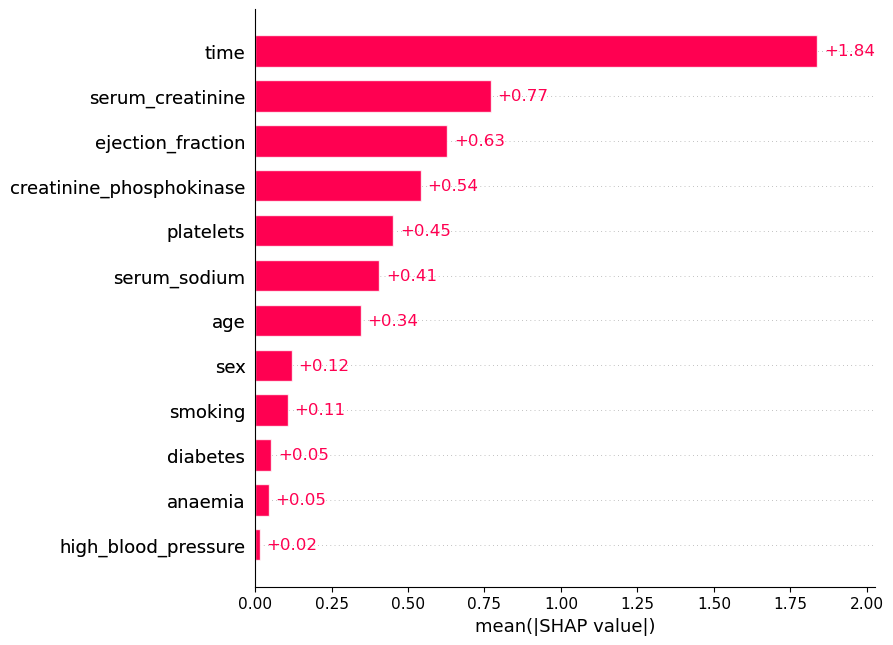

In [38]:
shap_values = explainer(X_test)

shap.plots.bar(shap_values, max_display=12)

<br>

## Part 4 - Predict Observations

In [39]:
arr = lr_clf.predict_proba(x_samples_0)
print("Logistic Regression probabilities for \"Lived\":")
print(arr)
print()
arr = lr_clf.predict_proba(x_samples_1)
print("Logistic Regression probabilities for \"Died\":")
print(arr)

Logistic Regression probabilities for "Lived":
[[0.79937398 0.20062602]]

Logistic Regression probabilities for "Died":
[[0.34908408 0.65091592]]


In [40]:
arr = dt_clf.predict_proba(x_samples_0)
print("Decision Tree probabilities for \"Lived\":")
print(arr)
print()
arr = dt_clf.predict_proba(x_samples_1)
print("Decision Tree probabilities for \"Died\":")
print(arr)

Decision Tree probabilities for "Lived":
[[1. 0.]]

Decision Tree probabilities for "Died":
[[0. 1.]]


In [41]:
arr = rf_classifier.predict_proba(x_samples_0)
print("Random Forest probabilities for \"Lived\":")
print(arr)
print()
arr = rf_classifier.predict_proba(x_samples_1)
print("Random Forest probabilities for \"Died\":")
print(arr)

Random Forest probabilities for "Lived":
[[0.69 0.31]]

Random Forest probabilities for "Died":
[[0.44 0.56]]


In [42]:
arr = xgb_clf.predict_proba(x_samples_0)
print("Xgboost probabilities for \"Lived\":")
print(arr)
print()
arr = xgb_clf.predict_proba(x_samples_1)
print("Xgboost probabilities for \"Died\":")
print(arr)

Xgboost probabilities for "Lived":
[[0.5103786 0.4896214]]

Xgboost probabilities for "Died":
[[0.07982033 0.92017967]]


<br>
<p>
For the two test samples: Decision Tree Classifier has the highest probabilities:

For Lived: [1, 0]
For Died: [0, 1]
</p>